# Dimensionality Reduction

The goal of this notebook is to study the intrinsic dimensionality of the $G(\tau)$ data present in the dataset.

## Finding the transformation

In [1]:
import numpy as np
import pandas as pd


/home/romain/.conda/envs/DRL/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/romain/.conda/envs/DRL/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
dataset = pd.read_csv("../G_training.csv",header=None)

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca.fit(dataset)
print(pca.explained_variance_ratio_)  


[9.62997245e-01 3.41155762e-02 2.33802608e-03 4.34765787e-04
 1.05421970e-04 8.41077782e-06 5.24935148e-07 2.80862337e-08
 1.31320070e-09 5.51151651e-11]


In [4]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.96299724 0.99711282 0.99945085 0.99988561 0.99999103 0.99999945
 0.99999997 1.         1.         1.        ]


It seems that the data can almost perfectly be compressed using 8 dimensions, istead of the 512. This could represent a huge gain for the training of neural networks. 

## Applying the transformation to Quantum Monte Carlo Data

The problem is that our QMC data do not contain the same number of sampling points. Indeed, for reason of correlation or computation time, some time steps are closer than other... 

In this section, we will try to generate the missing points by putting a smooth line between the data. 

In [5]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
#Import data
qmc_data_G = np.squeeze(pd.read_csv("../../MaxEnt/simulation_harm_osc.csv",usecols=[1]).as_matrix())
qmc_data_tau = np.squeeze(pd.read_csv("../../MaxEnt/simulation_harm_osc.csv",usecols=[0]).as_matrix())
# Interpolate the data
f = interp1d(qmc_data_tau, qmc_data_G, kind='cubic')
tau = np.linspace(qmc_data_tau[0], qmc_data_tau[-1], num=1024, endpoint=True)

# Plot data
plt.plot(qmc_data_tau,qmc_data_G, 'o',tau,f(tau),'--')
plt.legend(['data','splines'],loc='best')
plt.show()




/home/romain/.conda/envs/DRL/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/home/romain/.conda/envs/DRL/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


<Figure size 640x480 with 1 Axes>

 We can now transform the $f(\tau)$ using PCA transform !

In [6]:
reduced_G=pca.transform(f(tau).reshape(1,1024))
new_G = pca.inverse_transform(reduced_G[:][0:8])

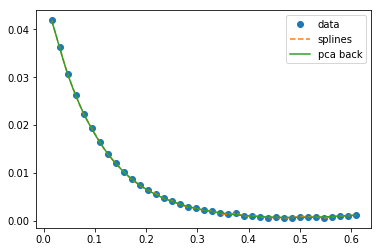

In [7]:
plt.plot(qmc_data_tau,qmc_data_G, 'o',tau,f(tau),'--',tau,new_G[0][:],'-')
plt.legend(['data','splines','pca back'],loc='best')
plt.show()



The transformation, keeping only the 8th first data, seems to keep the main features of $G(\tau)$

## Transforming the dataset

We can proceed to the transformation of the whole dataset :D

In [12]:
dataset = pd.read_csv("../G_training.csv",header=None)
pca_def = PCA(n_components=8)
pca_def.fit(dataset)




PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [13]:
dataset_coef = pca_def.transform(dataset)
pd.DataFrame(dataset_coef).to_csv("../G_training_reduced.csv",index=False,header=False)



In [14]:
validation_set = pd.read_csv("../G_validation.csv",header=None)
validation_set_coef = pca_def.transform(validation_set)
pd.DataFrame(validation_set_coef).to_csv("../G_validation_reduced.csv",index=False,header=False)